In [1]:
import os
import sys
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)
from BI import bi
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro import handlers
from jax import random, vmap


m = bi(platform='cpu')

/home/sosa/work/BI/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


jax.local_device_count 16


# Activation function

In [2]:
def activation(x):
    return jnp.tanh(x)

# Linear relationships

jax.local_device_count 16


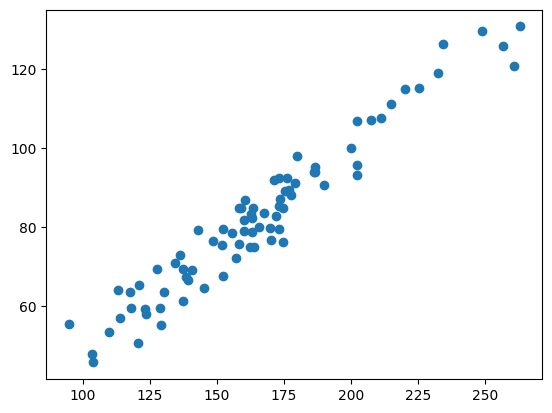

In [3]:

# setup platform------------------------------------------------
m = bi(platform='cpu')
alpha= 0.6
beta = 0.5
sigma= 5
x=m.dist.normal(160, 40,sample=True,shape=(100,))
lk=alpha+beta*x
y=m.dist.normal(lk, sigma,sample=True,seed=2)
data=jnp.array([x,y]).T

def split_train_test(arr):
    # Get the length of the array
    n = arr.shape[0]
    
    # Calculate the split index (80% for training)
    train_idx = int(n * 0.8)
    
    # Generate a random permutation of indices
    key = jax.random.PRNGKey(0)  # You can use a fixed key for reproducibility
    permuted_indices = jax.random.permutation(key, n)
    
    # Split the permuted indices
    train_indices = permuted_indices[:train_idx]
    test_indices = permuted_indices[train_idx:]
    
    # Split the original array based on the indices
    train_set = arr[train_indices]
    test_set = arr[test_indices]
    
    return train_set, test_set

train, test = split_train_test(data)

dataTrain= dict(X=train[:,0].reshape((train[:,0].shape[0],1)),Y=train[:,1].reshape((train[:,0].shape[0],1)))

m.data_on_model=dataTrain

plt.scatter(dataTrain['X'], dataTrain['Y'])

## Scaling data as activation function (tanh) concider values between -1 and 1.

In [4]:
X_mean = jnp.mean(dataTrain['X'], axis=0)
X_std = jnp.std(dataTrain['X'], axis=0)
Y_mean = jnp.mean(dataTrain['Y'], axis=0)
Y_std = jnp.std(dataTrain['Y'], axis=0)
X=(dataTrain['X'] - X_mean) / X_std
Y=(dataTrain['Y'] - Y_mean) / Y_std
m.data_on_model= dict(X=X, Y=Y)


### Model



In [5]:
def model(X, Y,  D_H=5, D_Y=1):  
    N, D_X = X.shape
    # sample first layer (we put unit normal priors on all weights)
    # First hidden layer: Transforms input to N × D_H (hidden units)
    w1 = m.dist.normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H)),  name='w1',shape=(D_X,D_H))
    z1 = activation(jnp.matmul(X, w1))  # <= first layer of activations

    # sample final layer of weights and neural network output
    # Final layer (z3) computes linear combination of second hidden layer
    w3 = m.dist.normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y)),  name='w2',shape=(D_H,D_Y))
    z3 = jnp.matmul(z1, w3)  # <= output of the neural network
    
    # we put a prior on the observation noise
    prec_obs = m.dist.gamma(3.0, 1.0,name='prec_obs')
    sigma_obs = 1.0 / jnp.sqrt(prec_obs)

    m.dist.normal(z3, sigma_obs, obs=Y,shape=(N,D_Y),name='Y')


# Run sampler ------------------------------------------------
m.run(model, num_samples=500) 

sample: 100%|██████████| 1000/1000 [00:07<00:00, 137.10it/s, 127 steps of size 2.06e-02. acc. prob=0.90]


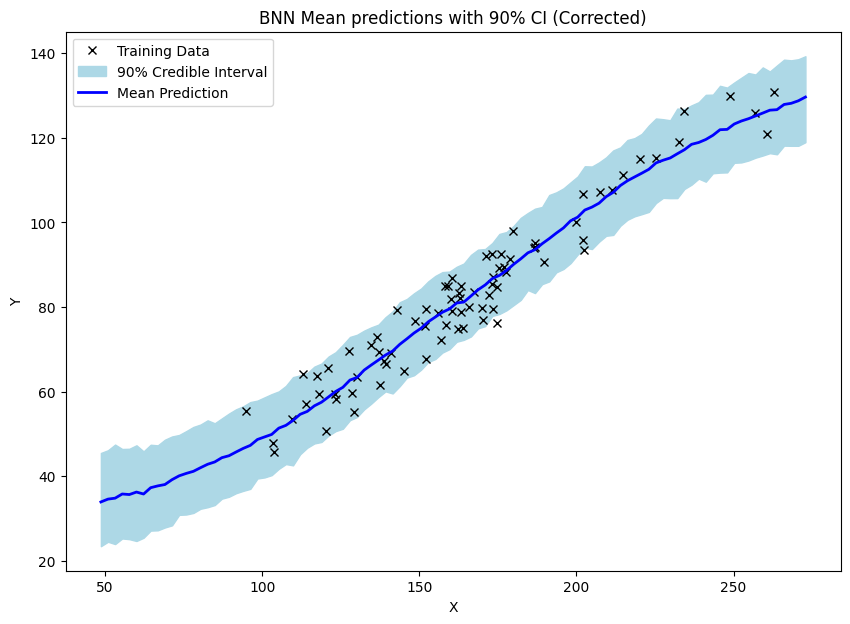

In [6]:

def predict(model, rng_key, samples, X, D_H):
    model_fn = handlers.substitute(handlers.seed(model, rng_key), samples)
    model_trace = handlers.trace(model_fn).get_trace(X=X, Y=None, D_H=D_H)
    return model_trace["Y"]["value"]

samples = m.posteriors
X_test = jnp.linspace(data[:, 0].min() - 10, data[:, 0].max() + 10, 100).reshape(-1, 1)
X_test_scaled = (X_test - X_mean) / X_std

vmap_args = (samples, random.split(random.PRNGKey(10), 500))
# These predictions are in the SCALED Y space
scaled_predictions = vmap(
    lambda s, k: predict(model, k, s, X_test_scaled, D_H=5)
)(*vmap_args)

# Squeeze the last dimension
scaled_predictions = scaled_predictions[..., 0]

# **IMPORTANT**: Un-scale the predictions back to the original data space
mean_prediction = scaled_predictions.mean(axis=0) * Y_std + Y_mean
percentiles = np.percentile(scaled_predictions, [5.0, 95.0], axis=0) * Y_std + Y_mean

# Make plots
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(dataTrain['X'], dataTrain['Y'], "kx", label="Training Data")
ax.fill_between(
    X_test.flatten(),
    percentiles[0, :],
    percentiles[1, :],
    color="lightblue",
    label="90% Credible Interval"
)
ax.plot(X_test.flatten(), mean_prediction.flatten(), "blue", ls="solid", lw=2.0, label="Mean Prediction")
ax.set(xlabel="X", ylabel="Y", title="BNN Mean predictions with 90% CI (Corrected)")
ax.legend()
plt.show()

# Non linear relationships

In [12]:
def get_data(N=50, D_X=1, sigma_obs=0.05, N_test=500):
    D_Y = 1  # create 1d outputs
    np.random.seed(0)
    X = jnp.linspace(-1, 1, N)
    X = jnp.power(X[:, np.newaxis], jnp.arange(D_X))
    W = 0.5 * np.random.randn(D_X)
    Y = jnp.dot(X, W) + 0.5 * jnp.power(0.5 + X[:, 1], 2.0) * jnp.sin(4.0 * X[:, 1])
    Y += sigma_obs * np.random.randn(N)
    Y = Y[:, np.newaxis]
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)

    assert X.shape == (N, D_X)
    assert Y.shape == (N, D_Y)

    X_test = jnp.linspace(-1.3, 1.3, N_test)
    X_test = jnp.power(X_test[:, np.newaxis], jnp.arange(D_X))

    return X, Y, X_test
X, Y, X_test = get_data(D_X = 2)


 ## We can use the same model as for non linear relationships

In [13]:

X=(X - jnp.mean(X))/jnp.std(X)
m.data_on_model=dict(X=X, Y=Y) 

# Run sampler ------------------------------------------------
m.run(model, num_samples=500) 

sample: 100%|██████████| 1000/1000 [00:09<00:00, 106.68it/s, 511 steps of size 1.05e-02. acc. prob=0.93]


[Text(0.5, 0, 'X'),
 Text(0, 0.5, 'Y'),
 Text(0.5, 1.0, 'Mean predictions with 90% CI')]

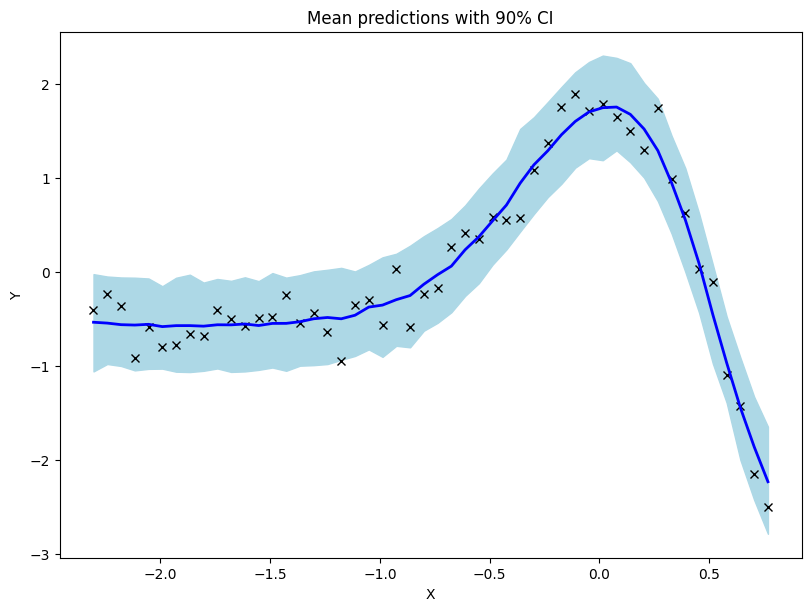

In [15]:
from numpyro import handlers
from jax import random, vmap
rng_key, rng_key_predict = random.split(random.PRNGKey(0))

def predict(model, rng_key, samples, X, D_H):
    model = handlers.substitute(handlers.seed(model, rng_key), samples)
    model_trace = handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H)
    return model_trace["Y"]["value"]


samples=m.sampler.get_samples()
vmap_args = (
    samples,
    random.split(rng_key_predict, 500 * 1),
)
predictions = vmap(
    lambda samples, rng_key: predict(model, rng_key, samples, X, 1)
)(*vmap_args)

predictions = predictions[..., 0]
mean_prediction = jnp.mean(predictions, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)
# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
# plot training data
ax.plot(X[:, 1], Y[:, 0], "kx")
# plot 90% confidence level of predictions
ax.fill_between(
    X[:, 1], percentiles[0, :], percentiles[1, :], color="lightblue"
)
# plot mean prediction
ax.plot(X[:, 1], mean_prediction, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")


# Testing neural network for covariance matrix

## Simulated data

In [20]:
import numpyro.distributions as dd
import pandas as pd

# setup platform------------------------------------------------
m = bi(platform='cpu')

a = 3.5  # average morning wait time
b = -1  # average difference afternoon wait time
sigma_a = 1  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes
Mu = jnp.array([a, b])
cov_ab = sigma_a * sigma_b * rho
Sigma = jnp.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]])
jnp.array([1, 2, 3, 4]).reshape(2, 2).T
sigmas = jnp.array([sigma_a, sigma_b])  # standard deviations
Rho = jnp.array([[1, rho], [rho, 1]])  # correlation matrix
print("original Rho")
print(Rho)
# now matrix multiply to get covariance matrix
Sigma = jnp.diag(sigmas) @ Rho @ jnp.diag(sigmas)

N_cafes = 20
seed = random.PRNGKey(5)  # used to replicate example
vary_effects = m.dist.multivariatenormal(Mu, Sigma, shape=(N_cafes,), sample = True)
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

seed = random.PRNGKey(22)
N_visits = 10
afternoon = jnp.tile(jnp.arange(2), N_visits * N_cafes // 2)
cafe_id = jnp.repeat(jnp.arange(N_cafes), N_visits)
mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
sigma = 0.5  # std dev within cafes
wait = m.dist.normal(mu, sigma, sample = True)
d = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))
#d.to_csv('../resources/data/Sim data multivariatenormal.csv', index=False)

jax.local_device_count 16
original Rho
[[ 1.  -0.7]
 [-0.7  1. ]]


## Covariance matrix using Cholesky decomposition

In [26]:
# import data ------------------------------------------------
m = bi()
m.df = d

m.data_on_model = dict(
    cafe = jnp.array(m.df.cafe.values, dtype=jnp.int32),
    wait = jnp.array(m.df.wait.values, dtype=jnp.float32),
    N_cafes = len(m.df.cafe.unique()),
    afternoon = jnp.array(m.df.afternoon.values, dtype=jnp.float32)
)

def model(cafe, wait, N_cafes, afternoon):
    a = m.dist.normal(5, 2,  name = 'a')
    b = m.dist.normal(-1, 0.5, name = 'b')
    sigma = m.dist.exponential( 1,  name = 'sigma')

    sigma_cafe = m.dist.exponential(1, shape=(2,),  name = 'sigma_cafe')    
    Rho = m.dist.lkj(2, 2, name = 'Rho')
    cov = jnp.outer(sigma_cafe, sigma_cafe) * Rho
    a_cafe_b_cafe = m.dist.multivariatenormal(jnp.stack([a, b]), cov, shape = [N_cafes], name = 'a_b_cafe')    

    a_cafe, b_cafe = a_cafe_b_cafe[:, 0], a_cafe_b_cafe[:, 1]
    mu = a_cafe[cafe] + b_cafe[cafe] * afternoon
    m.dist.normal(mu, sigma, obs=wait)

# Run sampler ------------------------------------------------
m.run(model) 



jax.local_device_count 16


sample: 100%|██████████| 1000/1000 [00:08<00:00, 122.38it/s, 15 steps of size 2.97e-01. acc. prob=0.90]


In [29]:
# import data ------------------------------------------------
m2 = bi()
m2.df = d

m2.data_on_model = dict(
    cafe = jnp.array(m.df.cafe.values, dtype=jnp.int32),
    wait = jnp.array(m.df.wait.values, dtype=jnp.float32),
    N_cafes = len(m.df.cafe.unique()),
    afternoon = jnp.array(m.df.afternoon.values, dtype=jnp.float32)
)

def model(cafe, wait, N_cafes, afternoon):
    # Global parameters for intercept and slope
    a = m2.dist.normal(5, 2, name='a')
    b = m2.dist.normal(-1, 0.5, name='b')
    sigma = m2.dist.exponential(1, name='sigma')
    
    # --- Replace the covariance approach with a neural network ---
    # Bayesian neural network parameters for a two–layer MLP
    hidden_dim = 10  # you can change the hidden layer size
    # First layer weights/biases: note these are treated as latent parameters
    W1 = m2.dist.normal(0, 1, shape=(N_cafes, hidden_dim), name='W1')
    # Second layer weights/biases
    W2 = m2.dist.normal(0, 1, shape=(hidden_dim, 2), name='W2')

    # Create one-hot encoding for each cafe (each row is a one–hot vector)
    X = jnp.eye(N_cafes)  # shape: (N_cafes, N_cafes)    
    # First layer: project one-hot into a hidden representation
    hidden = jnp.tanh(jnp.dot(X, W1))  # shape: (N_cafes, hidden_dim)
    
    # Second layer: output two values per cafe (offsets for a and b)
    delta = jnp.dot(hidden, W2)        # shape: (N_cafes, 2)    
    
    # Neural network outputs serve as offsets to the global parameters.
    # This replaces the multivariate normal draw for a_cafe_b_cafe.
    a_cafe_b_cafe = numpyro.deterministic('a_cafe_b_cafe', jnp.stack([a, b]) + delta)  # shape: (N_cafes, 2)
    
    # Split the network output into cafe-specific intercept and slope
    a_cafe, b_cafe = a_cafe_b_cafe[:, 0], a_cafe_b_cafe[:, 1]
    mu = a_cafe[cafe] + b_cafe[cafe] * afternoon
    
    m2.dist.normal(mu, sigma, obs=wait)

# Run sampler ------------------------------------------------
m2.run(model)



jax.local_device_count 16


sample: 100%|██████████| 1000/1000 [00:07<00:00, 127.12it/s, 127 steps of size 4.44e-02. acc. prob=0.90]


## Comparaison of covariance matrix with Choleslesky decomposition and with neural network

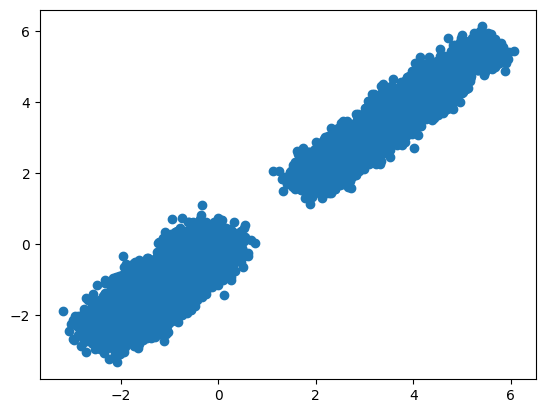

In [30]:
plt.scatter(m.posteriors['a_b_cafe'],m2.posteriors['a_cafe_b_cafe'])

## Recovering RHo of BNN

In [32]:
import jax
import jax.numpy as jnp
def recover_Rho(posterior):
    # Assume a_cafe_b_cafe is a JAX array of shape (N_cafes, 2), where each row is [a_cafe, b_cafe]

    a_cafe_b_cafe =jnp.mean(posterior, axis=0) 
    N_cafes = a_cafe_b_cafe.shape[0]

    # 1. Compute sample covariance matrix
    mean_a_b_cafe = jnp.mean(a_cafe_b_cafe, axis=0)  # Mean of [a_cafe, b_cafe]

    centered_data = a_cafe_b_cafe - mean_a_b_cafe  # Center data by subtracting the mean

    cov_sample = jnp.dot(centered_data.T, centered_data) / (N_cafes - 1)  # Covariance matrix

    # 2. Extract sigma_cafe (standard deviations) from the diagonal of the covariance matrix
    sigma_cafe = jnp.sqrt(jnp.diagonal(cov_sample))  # Extract standard deviations (sqrt of variance)

    # 3. Compute Rho (correlation matrix)
    rho = cov_sample / (sigma_cafe[:, None] * sigma_cafe[None, :])  # Normalize covariance to obtain correlation matrix

    # Display the results
    print("Covariance matrix (Sigma):")
    print(cov_sample)
    print("\nStandard deviations (sigma_cafe):")
    print(sigma_cafe)
    print("\nCorrelation matrix (Rho):")
    print(rho)
    #return cov_sample, sigma_cafe, rho


print('\nm2 estimations covariance estimations (neural network)')
recover_Rho(m2.posteriors['a_cafe_b_cafe'])

print('\nm1 estimations covariance estimations (LKJ prior)')
print(jnp.mean(m.posteriors['Rho'], axis = 0))

print("\nSimulated values-------------------------------------------------------")
print("\nCorrelation matrix (Rho):")
print(Rho)
print("Covariance matrix (Sigma):")
print(Sigma)
print("\nStandard deviations (sigma_cafe):")
print(sigmas)




m2 estimations covariance estimations (neural network)
Covariance matrix (Sigma):
[[ 0.80896059 -0.3622663 ]
 [-0.3622663   0.44815923]]

Standard deviations (sigma_cafe):
[0.89942237 0.66944696]

Correlation matrix (Rho):
[[ 1.         -0.60165575]
 [-0.60165575  1.        ]]

m1 estimations covariance estimations (LKJ prior)
[[ 1.         -0.50451534]
 [-0.50451534  1.        ]]

Simulated values-------------------------------------------------------

Correlation matrix (Rho):
[[ 1.  -0.7]
 [-0.7  1. ]]
Covariance matrix (Sigma):
[[ 1.   -0.35]
 [-0.35  0.25]]

Standard deviations (sigma_cafe):
[1.  0.5]


## Explanation

### Global parameters:
The model still defines overall intercept $a$ and slope $b$ as well as the observation noise $\sigma$.

### Neural network prior:
Instead of drawing each cafe’s $[a_{\text{cafe}}, b_{\text{cafe}}]$ from a multivariate normal with a structured covariance, we define a small MLP.

- The input $X$ is an identity matrix (one–hot encoding for each cafe).
- The first layer (with weights $W_1$ and biases $b_1$) maps the one–hot vectors into a hidden space using a $\tanh$ activation.
- The second layer (with weights $W_2$ and biases $b_2$) outputs a 2–dimensional vector for each cafe, which acts as an offset.

### Combining with global parameters:
Adding the network’s output $\delta$ to the global $[a, b]$ produces the cafe–specific parameters $a_{\text{cafe\_b\_cafe}}$. These are then used as before to form the linear predictor $\mu$.

This approach replaces the covariance specification with a more flexible neural network prior that may capture complex variations across cafes.

## Cons
In this version ther is no equivalent of Rho returned.


In [35]:
# import data ------------------------------------------------
m3 = bi()


m3.data_on_model = dict(
    cafe = jnp.array(m.df.cafe.values, dtype=jnp.int32),
    wait = jnp.array(m.df.wait.values, dtype=jnp.float32),
    N_cafes = len(m.df.cafe.unique()),
    afternoon = jnp.array(m.df.afternoon.values, dtype=jnp.float32)
)

def model(cafe, wait, N_cafes, afternoon):
    # Global parameters for intercept and slope
    a = m3.dist.normal(5, 2, name='a')
    b = m3.dist.normal(-1, 0.5, name='b')
    sigma = m3.dist.exponential(1, name='sigma')
    
    # --- Global correlation parameter (equivalent of Rho) ---
    Rho = m3.dist.lkj(2, 2, name='Rho')  # 2x2 correlation matrix
    
    # --- Neural network for cafe-specific adjustments ---
    # The NN will output both an offset (delta) and log-scales (for the covariance) for each cafe.
    hidden_dim = 10  # size of hidden layer
    
    # First layer: from one-hot (N_cafes x N_cafes) to hidden representation
    W1 = m3.dist.normal(0, 1, shape=(N_cafes, hidden_dim), name='W1')
    b1 = m3.dist.normal(0, 1, shape=(hidden_dim,), name='b1')
    
    # Second layer: outputs 4 values per cafe:
    #   first two: offsets for intercept and slope,
    #   next two: log-scales for intercept and slope.
    W2 = m3.dist.normal(0, 1, shape=(hidden_dim, 4), name='W2')
    b2 = m3.dist.normal(0, 1, shape=(4,), name='b2')
    
    # One-hot encoding for each cafe (each row corresponds to one cafe)
    X = jnp.eye(N_cafes)  # shape: (N_cafes, N_cafes)
    
    # First layer activation
    hidden = jnp.tanh(jnp.dot(X, W1) + b1)  # shape: (N_cafes, hidden_dim)
    
    # Second layer outputs (raw NN outputs)
    nn_out = jnp.dot(hidden, W2) + b2  # shape: (N_cafes, 4)
    
    # Split the NN outputs:
    # - delta: offsets for a and b (shape: [N_cafes, 2])
    # - log_sigma_cafe: log-scales for a and b (shape: [N_cafes, 2])
    delta = nn_out[:, :2]
    log_sigma_cafe = nn_out[:, 2:]
    sigma_cafe = jnp.exp(log_sigma_cafe)  # ensures positive scales, shape: (N_cafes, 2)
    
    # Construct a covariance matrix for each cafe using the NN–derived scales and global Rho.
    # For each cafe, cov = outer(sigma_cafe[i], sigma_cafe[i]) * Rho
    cov_list = []
    for i in range(N_cafes):
        cov_i = jnp.outer(sigma_cafe[i], sigma_cafe[i]) * Rho
        cov_list.append(cov_i)
    cov = jnp.stack(cov_list, axis=0)  # shape: (N_cafes, 2, 2)
    
    # Mean for each cafe: global parameters plus NN–derived offsets
    mu_cafe = jnp.stack([a, b]) + delta  # shape: (N_cafes, 2)
    
    # Draw cafe–specific intercepts and slopes with the neural network–guided covariance.
    a_cafe_b_cafe = m3.dist.multivariatenormal(mu_cafe, cov, shape=[N_cafes], name='a_b_cafe')
    a_cafe, b_cafe = a_cafe_b_cafe[:, 0], a_cafe_b_cafe[:, 1]
    
    # Likelihood for the observed wait times
    mu = a_cafe[cafe] + b_cafe[cafe] * afternoon
    m3.dist.normal(mu, sigma, obs=wait)

# Run sampler ------------------------------------------------
m3.run(model)



jax.local_device_count 16


sample: 100%|██████████| 1000/1000 [01:18<00:00, 12.81it/s, 1023 steps of size 6.77e-04. acc. prob=0.89]


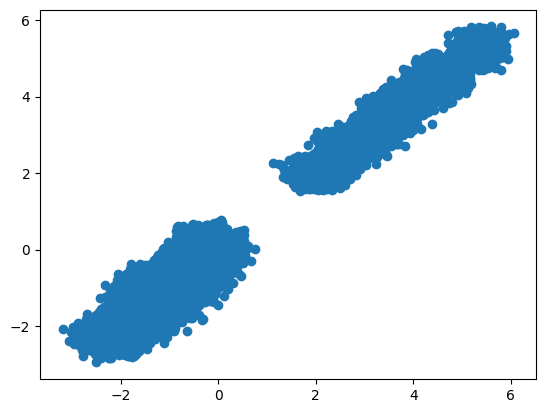

In [38]:
plt.scatter(m.posteriors['a_b_cafe'],m3.posteriors['a_b_cafe'])

In [39]:
import numpy as np

def is_positive_definite(matrix):
    try:
        np.linalg.cholesky(matrix)
        return True
    except np.linalg.LinAlgError:
        return False


print(is_positive_definite(jnp.mean(m.posteriors['Rho'], axis = 0))) 

print(is_positive_definite(jnp.mean(m3.posteriors['Rho'], axis = 0)))  # Output: True


True
True


## Explanation

### Global Correlation ($\rho$):  
The variable `Rho` is still drawn from an LKJ prior and represents the common 2×2 correlation matrix across cafes. This is analogous to the original model’s `Rho`.

### Neural Network Outputs:  
The NN now outputs 4 numbers per cafe:  

- The first two (`delta`) are additive offsets to the global $a$ and $b$.  
- The next two are used (after exponentiation) as scale parameters ($\sigma_{\text{cafe}}$) for each cafe.  

### Covariance Construction:  
For each cafe, the covariance matrix is constructed using the NN–derived scales and the global correlation matrix, via  

\[
\text{cov}_i = \text{outer}(\sigma_{\text{cafe}, i}, \sigma_{\text{cafe}, i}) \times \rho.
\]

This preserves an explicit role for $\rho$ while allowing the NN to provide flexible, cafe–specific scaling.  

This version therefore provides an equivalent of the original `Rho` while still using the neural network to inform the cafe–specific parameters.
